## Auto-correlation of volatility

In this workbook, we look at the auto-correlation between returns and volatility and see whether it could be used to add some predictive edge.

Auto-correlation is the correlation of a series with itself over a specified time lag. 

A simple definition could be found [here](https://www.investopedia.com/terms/a/autocorrelation.asp)


In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [2]:
df = pd.read_csv('/home/pi/data/nifty.csv', parse_dates=['Date']).rename(
columns = lambda x:x.lower()).sort_values(by='date').set_index('date')
df['ret'] = df.close.pct_change()
df.tail()

,open,high,low,close,ret
date,,,,,
2021-09-30,17718.90,17742.15,17585.35,17618.15,-0.005259
2021-10-01,17531.90,17557.15,17452.90,17532.05,-0.004887
2021-10-04,17615.55,17750.90,17581.35,17691.25,0.009081
2021-10-05,17661.35,17833.45,17640.90,17822.30,0.007408
2021-10-06,17861.50,17884.60,17613.15,17646.00,-0.009892


Let us calculate the monthly returns and the volatility.

 * For volatility, I would be calculating a simple standard deviation of the daily returns 
 * I would be using the close price instead of the adjusted close price. (Use adjusted close for stocks since they are prone to splits and other corporate actions that has a big impact on price)

In [7]:
monthly_returns = df.resample('M').close.ohlc().close.pct_change()
monthly_volatility = df.resample('M').ret.std()

<AxesSubplot:title={'center':'Monthly volatility (in %)'}, xlabel='date'>

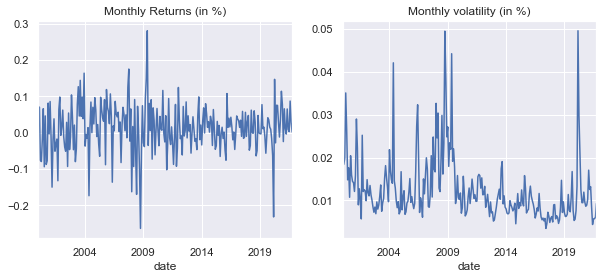

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

monthly_returns.plot(title='Monthly Returns (in %)', ax=axes[0])
monthly_volatility.plot(title='Monthly volatility (in %)', ax=axes[1])

So, we could see a big spike in volatility in the expected periods , the 2008 financial crisis and the 2020 covid crisis. We can also observe the big dip in returns.


In [27]:
print(f"Autocorrelation for returns = {monthly_returns.autocorr() :.4f}")
print(f"Autocorrelation for volatility = {monthly_volatility.autocorr() :.4f}")

Autocorrelation for returns = 0.0273
Autocorrelation for volatility = 0.5860


Hurrah! There is a big correlation between this month and next month's volatility.


Let us do the auto-correlation plot for different months.


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

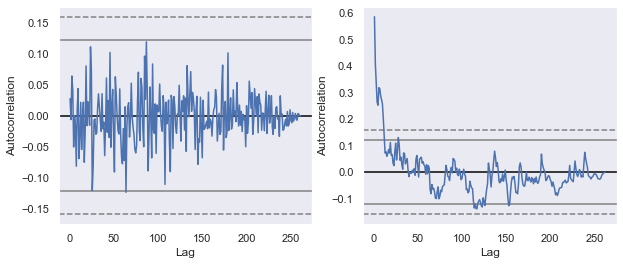

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
pd.plotting.autocorrelation_plot(monthly_returns.dropna(), ax=axes[0])
pd.plotting.autocorrelation_plot(monthly_volatility.dropna(),ax=axes[1])

In [44]:
for i in range(1,7):
    print(f"Auto-correlation for month {i} = {monthly_volatility.autocorr(lag=i) :.4f}")
    

Auto-correlation for month 1 = 0.5860
Auto-correlation for month 2 = 0.4094
Auto-correlation for month 3 = 0.3352
Auto-correlation for month 4 = 0.2714
Auto-correlation for month 5 = 0.2622
Auto-correlation for month 6 = 0.3315


From the above plots, it is clear that returns are random and previous 1 month or 2 months returns doesn't have a big impact in the forthcoming months. So, if you see some positive returns for some months, the next month may not necessarily have positive return and vice-versa; same with the second or third month. The unconditional probability of returns being positive or negative is 50% - equivalent to coin toss.

But the volatility has a good auto-correlation that extends to even 6 months, which suggests that volatility even though it shoots up suddenly has a lasting effect. The volatility of this month is going to be likely that of the previous month and there i

 * For a detailed description of autocorrelation, you could look at the [wikipedia page](https://en.wikipedia.org/wiki/Autocorrelation)
 
 * This [kaggle notebook](https://www.kaggle.com/jeegarmaru/timeseriesanalysis-autocorrelation) has a rich set of python code on this topic
 
 * Though returns don't have autocorrelation and so the probability of positive or negative returns is 50%, there is a slight edge if the probability is conditioned on some variable.